# Effects of Loan Characteristics on BorrowerRate

## by Princess Obazee

## Investigation Overview

In this investigation, I wanted to look at the characteristics of Loans that could be used to predict the BorrowerRate. the main focus is the features that could affect the BorrowerRate, which are LoanOriginalAmount, ProsperRating (Alpha), Term, and StatedMonthlyIncome.

## Dataset Overview

The dataset consisted of 113,937 loans with 81 variables on each loan, including loan amount, borrower rate (or interest rate), current loan status, borrower income, and many others. 28,812 data points from the CreditGrade variable was used to fill the null values in the ProsperRating (Alpha) feature as these data points are Ratings for pre-2009 loans. 66 data points were removed from the dataset from the analysis due to very large stated monthly income seemed as outliers and missing borrower APR information.

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

In [2]:
# load in the dataset into a pandas dataframe
Loan_df= pd.read_csv('prosperLoanData.csv')

#copy the original data
Rating = Loan_df.copy()

#filter to where Prosper Ratings were not specified which is for pre-July 2009 loans
Rating = Rating[Rating['ProsperRating (Alpha)'].isnull()]

#fill the null ProsperRating with the rating in CreditGrade
Rating['ProsperRating (Alpha)']= Rating['CreditGrade']

#assign the populated ProsperRating to the original df
mask= Loan_df['ProsperRating (Alpha)'].isnull()
column_name = ['ProsperRating (Alpha)']
Loan_df.loc[mask, column_name] = Rating

#replace NC rating with NaN as the rating is not used by ProsperLoan
Loan_df['ProsperRating (Alpha)'] = Loan_df['ProsperRating (Alpha)'].replace('NC', np.NaN)

#select columns (features) relevant to loan data exploration
Loan_df = Loan_df[['BorrowerRate','BorrowerAPR','LoanOriginalAmount','StatedMonthlyIncome','Term','ProsperRating (Alpha)', 
                     'EmploymentStatus', 'LoanCurrentDaysDelinquent','MonthlyLoanPayment']] 

#remove outliers from
Outliers = (Loan_df['StatedMonthlyIncome'] > 60000)
Loan_df = Loan_df.loc[-Outliers,:]

# Convert ProsperRating (Alpha) to ordered categorical types
ProsperRate= ['HR','E','D','C','B','A','AA']
Ordered_ProsperRate = pd.api.types.CategoricalDtype(ordered = True,
                                    categories = ProsperRate)
Loan_df['ProsperRating (Alpha)'] = Loan_df['ProsperRating (Alpha)'].astype(Ordered_ProsperRate)

#group LoanCurrentDaysDelinquent into categories
bin_edges=[0,1,31,61,91,121,181,2705]
bin_names= ['Ongoing', 'Past Due(1-30 Days)', 'Past Due(31-60 Days)', 'Past Due(61-90 Days)', 
            'Past Due(91-120 Days)', 'Past Due(121-180 Days)', 'Past Due(>180 Days)']
Loan_df['DelinquentBucket'] = pd.cut(Loan_df['LoanCurrentDaysDelinquent'], bin_edges, labels=bin_names, right = False)
Loan_df.shape

(113871, 10)

# Distribution of BorrowerRate

The BorrowerRate or Interest Rate distribution looks roughly multimodal, with one peak at 16%, a very high peak at 32%, and a small peak at 36%.

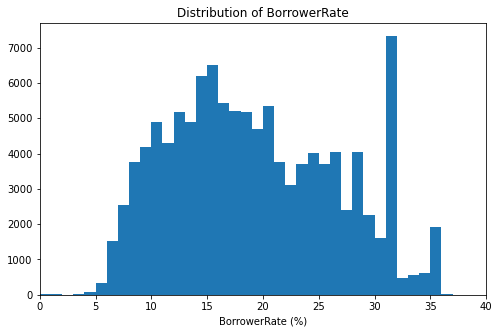

In [3]:
InterestRate= Loan_df['BorrowerRate'] * 100
bins = np.arange(0, Loan_df.BorrowerRate.max()*100 +1, 1)
plt.figure(figsize=[8, 5])
plt.hist(x = InterestRate, bins = bins)
plt.xlabel('BorrowerRate (%)')
plt.title('Distribution of BorrowerRate')
plt.xlim(0,40);

# Distribution of LoanOriginalAmount

The LoanOriginalAmount shows that round figure loan amounts with additional 500 dollars tend to have higher frequency than loan amounts in multiples of 1000. The highest peaks of the loan amounts are at: \\$4500, \\$10500, \\$15500, \\$20500 and \\$25500.

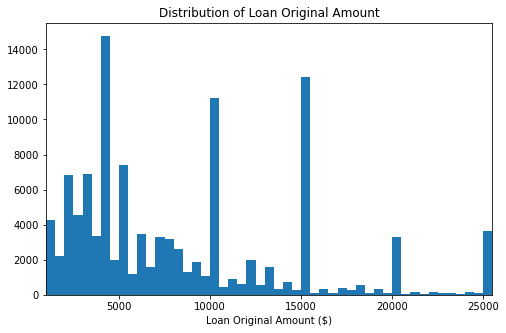

In [4]:
bins = np.arange(1000, Loan_df.LoanOriginalAmount.max()+500, 500)
plt.figure(figsize=[8, 5])
plt.hist(data = Loan_df, x = 'LoanOriginalAmount', bins = bins)
plt.xlabel('Loan Original Amount ($)')
plt.xlim(1000, 25500)
plt.title('Distribution of Loan Original Amount');

# BorrowerRate vs LoanOriginalAmount

The range of the BorrowerRate decreases as the LoanOriginalAmount increases. This indicates a negative correlation between the BorrowerRate and LoanOriginalAmount.

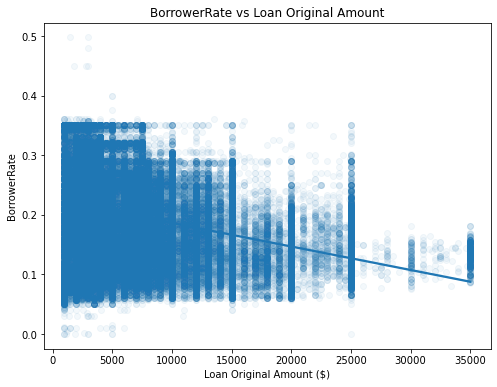

In [5]:
plt.figure(figsize = [8, 6])
sb.regplot(data = Loan_df, x = 'LoanOriginalAmount', y = 'BorrowerRate', scatter_kws={'alpha':0.05})
plt.xlabel('Loan Original Amount ($)')
plt.title('BorrowerRate vs Loan Original Amount');

# BorrowerRate vs ProsperRating (Alpha)

The BorrowerRate gradually decreases as borrowers have better Prosper ratings. Borrowers with the best Prosper ratings have the lowest BorrowerRate. This indicates Prosper rating has a strong effect on BorrowerRate.

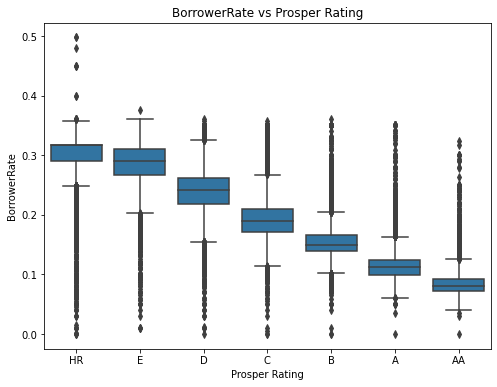

In [6]:
plt.figure(figsize=[8,6])
color = sb.color_palette()[0]
sb.boxplot(data= Loan_df, x='ProsperRating (Alpha)', y='BorrowerRate', color= color)
plt.xlabel('Prosper Rating')
plt.title('BorrowerRate vs Prosper Rating');

# BorrowerRate and LoanOriginalAmount by ProsperRating (Alpha)

The LoanOriginalAmount increases as the ProsperRating (Alpha) becomes higher. The BorrowerRate gradually decreases as the credit rating gets better.

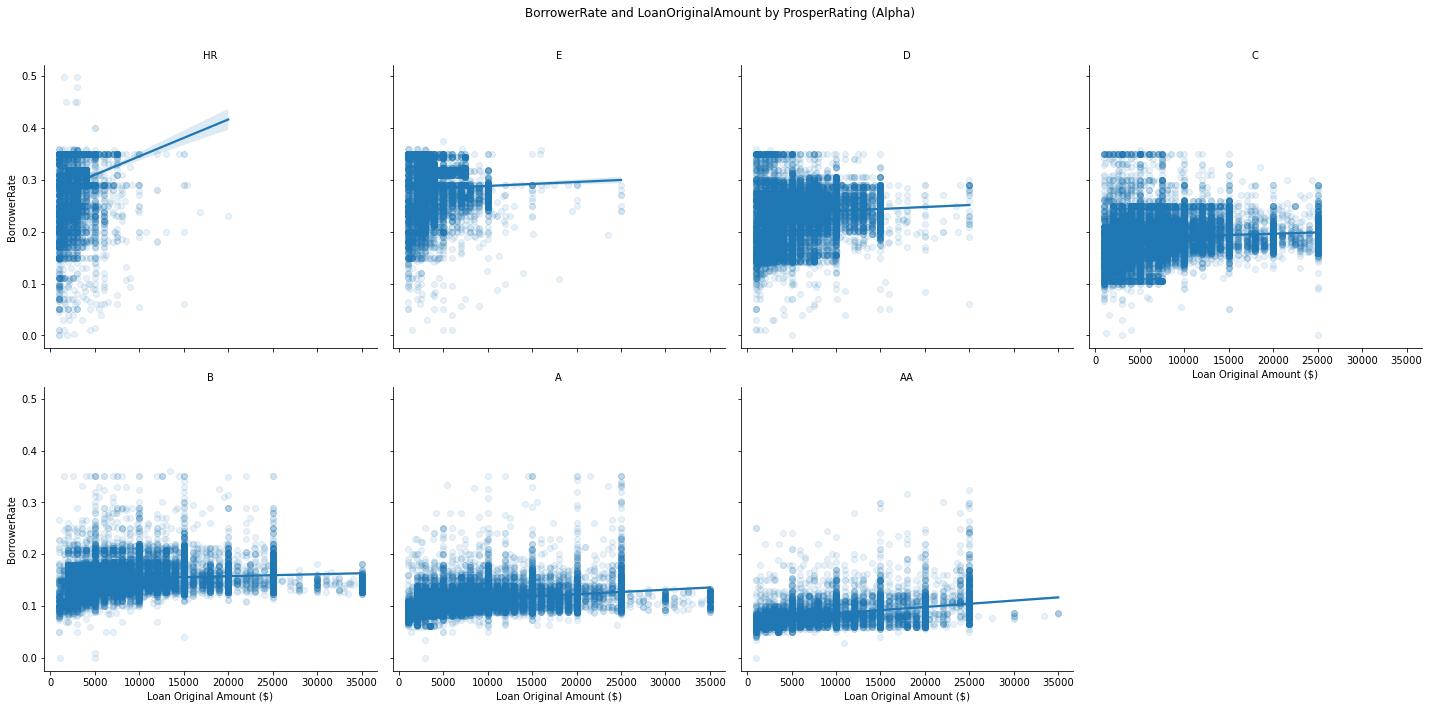

In [7]:
g=sb.FacetGrid(data=Loan_df, aspect=1, height=5, col='ProsperRating (Alpha)', col_wrap=4)
g.map(sb.regplot, 'LoanOriginalAmount', 'BorrowerRate', x_jitter=0.04, scatter_kws={'alpha':0.1});
g.add_legend()
g.set_titles('{col_name}')
g.set_xlabels('Loan Original Amount ($)')
g.set_ylabels('BorrowerRate')
plt.suptitle('BorrowerRate and LoanOriginalAmount by ProsperRating (Alpha)')
plt.subplots_adjust(top=0.90);

# BorrowerRate and ProsperRating (Alpha) by Term

The BorrowerRate decreases as the ProsperRating gets better. Interestingly, 60 month tenured loans generally have higher BorrowerRate than other tenured loans as the Rating gets better except for the HR rating where the BorrowerRate is the highest with only the 36 month termed loan.

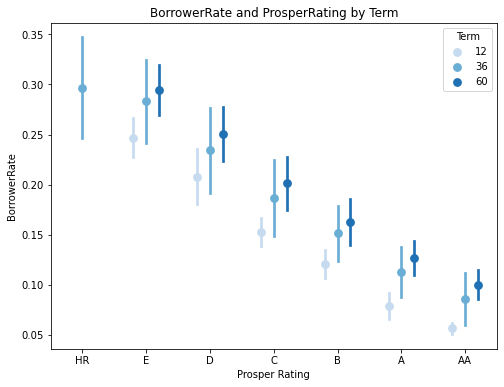

In [8]:
plt.figure(figsize = [8,6])
sb.pointplot(data = Loan_df, x = 'ProsperRating (Alpha)', y = 'BorrowerRate', hue = 'Term',
           palette = 'Blues', linestyles = '', dodge = 0.4, ci='sd')
plt.xlabel('Prosper Rating')
plt.title('BorrowerRate and ProsperRating by Term');

In [9]:
!jupyter nbconvert Project_3_Explanatory_Analysis.ipynb --to slides --post serve --no-input --no-prompt

[NbConvertApp] WARNING | Config option `kernel_spec_manager_class` not recognized by `NbConvertApp`.
[NbConvertApp] Converting notebook Project_3_Explanatory_Analysis.ipynb to slides
[NbConvertApp] Writing 1056881 bytes to Project_3_Explanatory_Analysis.slides.html
[NbConvertApp] Redirecting reveal.js requests to https://cdnjs.cloudflare.com/ajax/libs/reveal.js/3.5.0
Traceback (most recent call last):
  File "C:\Users\pobazee\Anaconda3\Scripts\jupyter-nbconvert-script.py", line 10, in <module>
    sys.exit(main())
  File "C:\Users\pobazee\Anaconda3\lib\site-packages\jupyter_core\application.py", line 264, in launch_instance
    return super(JupyterApp, cls).launch_instance(argv=argv, **kwargs)
  File "C:\Users\pobazee\Anaconda3\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
    app.start()
  File "C:\Users\pobazee\Anaconda3\lib\site-packages\nbconvert\nbconvertapp.py", line 369, in start
    self.convert_notebooks()
  File "C:\Users\pobazee\Anaconda3\l